In [145]:
%cd C:\Users\Admin\Downloads\dataset

C:\Users\Admin\Downloads\dataset


## Environment and Public Variables

In [146]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Dùng cho heatmap đẹp hơn
import os
from pathlib import Path
from collections import defaultdict
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    f1_score,
    precision_score,
    recall_score,
    jaccard_score,
    roc_auc_score,
    average_precision_score,
    classification_report
)
import cv2 
import segmentationmetrics
from tqdm import tqdm

In [147]:
# --- 1. Thiết lập chung cho Matplotlib ---
# (Giữ nguyên như code của bạn)
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 12
})
pred_dir = Path(r"pack\outputs\4.3_model_teacher\2025_11_18-16_58_15\csv")
gt_dir = Path(r"pack\ground_truth\csv")
output_dir = "eda_visualizations"
os.makedirs(output_dir, exist_ok=True)
print(f"Sẵn sàng phân tích. Sẽ lưu biểu đồ vào thư mục: '{output_dir}'")

defined_label_order = [
            'Nhóm 1 - Đậm độ - 1.1 Đặc',
            'Nhóm 1 - Đậm độ - 1.2 Bán đặc',
            'Nhóm 1 - Đậm độ - 1.3 Kính mờ',
            'Nhóm 1 - Đậm độ - 1.4 Đông đặc',
            'Nhóm 2 - Đậm độ vôi - 2.1 Không có vôi',
            'Nhóm 2 - Đậm độ vôi - 2.2 Có vôi',
            'Nhóm 2 - Đậm độ vôi - 2.2 Vôi trung tâm',
            'Nhóm 2 - Đậm độ vôi - 2.3 Vôi dạng lá',
            'Nhóm 2 - Đậm độ vôi - 2.4 Vôi lan toả',
            'Nhóm 2 - Đậm độ vôi - 2.5 Vôi dạng bắp',
            'Nhóm 2 - Đậm độ vôi - 2.6 Vôi lấm tấm',
            'Nhóm 2 - Đậm độ vôi - 2.7 Vôi lệch tâm',
            'Nhóm 3 - Đậm độ mỡ - 3.1 Không chứa mỡ',
            'Nhóm 3 - Đậm độ mỡ - 3.2 Có chứa mỡ',
            'Nhóm 4 - Bờ và Đường viền - 4.1 Tròn đều',
            'Nhóm 4 - Bờ và Đường viền - 4.2 Đa thuỳ',
            'Nhóm 4 - Bờ và Đường viền - 4.3 Bờ không đều',
            'Nhóm 4 - Bờ và Đường viền - 4.4 Tua gai',
            'Nhóm 5 - Tạo hang - 5.1 Không có',
            'Nhóm 5 - Tạo hang - 5.2 Hang lành tính',
            'Nhóm 5 - Tạo hang - 5.3 Hang ác tính',
            'Nhóm 6 - Di căn phổi - 6.0 - Không di căn',
            'Nhóm 6 - Di căn phổi - 6.1 - Di căn cùng bên',
            'Nhóm 6 - Di căn phổi - 6.2 - Di căn đối bên',
            'Tổn thương viêm - 1. Đông đặc',
            'Tổn thương viêm - 2. Kính mờ',
            'Tổn thương viêm - 3. Hình phế quản đồ',
            'Tổn thương viêm - 4. Nốt mờ dạng nụ trên cành'
        ]

Sẵn sàng phân tích. Sẽ lưu biểu đồ vào thư mục: 'eda_visualizations'


## Utils

In [148]:
neg_filter = lambda src: [max(0, element) for element in src]
pred_func = lambda src: [1 if el >= 0.5 else 0 for el in src]

In [149]:
def extend_lib(src, dst):
    if dst is None:
        dst = defaultdict(list)
    for key in src.keys():
        if not isinstance(src[key], list):
            dst[key].append(src[key])
        else:
            dst[key].extend(src[key])
    return dst

## Ground truth Evaluation

In [150]:
def run_full_eda(gt_csv_dir, out_dir):
    """Hàm chính chạy toàn bộ quy trình EDA."""

    # --- 2. Tải và Hợp nhất Dữ liệu ---
    # (Giữ nguyên như code của bạn)
    csv_files = glob.glob(str(gt_csv_dir / 'CTB-*.csv'))
    
    if not csv_files:
        print("Lỗi: Không tìm thấy file CTB-*.csv nào trong thư mục.")
        return
    df_list = [pd.read_csv(f) for f in csv_files]
    full_df = pd.concat(df_list, ignore_index=True)
    full_df["Nhóm 2 - Đậm độ vôi - 2.2 Có vôi"] = full_df[['Nhóm 2 - Đậm độ vôi - 2.2 Vôi trung tâm',
            'Nhóm 2 - Đậm độ vôi - 2.3 Vôi dạng lá',
            'Nhóm 2 - Đậm độ vôi - 2.4 Vôi lan toả',
            'Nhóm 2 - Đậm độ vôi - 2.5 Vôi dạng bắp',
            'Nhóm 2 - Đậm độ vôi - 2.6 Vôi lấm tấm',
            'Nhóm 2 - Đậm độ vôi - 2.7 Vôi lệch tâm']].max(axis=1)
    print(f"Đã tải và gộp {len(csv_files)} file. Tổng cộng {len(full_df)} hàng (lát cắt).")

    try:
        # --- 3. Tách Dữ liệu và Xác định Nhãn ---
        # (Giữ nguyên như code của bạn)
        start_col_index = full_df.columns.get_loc('left_lung') + 1
        label_cols = full_df.columns[start_col_index:]
        print(f"Đã xác định được {len(label_cols)} cột đặc điểm (label).")

        positive_df = full_df[full_df['mask_id'].notna()].copy()
        negative_df = full_df[full_df['mask_id'].isna()]
        print(f"Phân tích: {len(positive_df)} mẫu 'Dương tính' và {len(negative_df)} mẫu 'Âm tính'.")

        positive_df[label_cols] = positive_df[label_cols].astype(int)


        # --- 4. Trực quan hóa ---

        # 4.1. Biểu đồ 1: Positive vs Negative
        # (Giữ nguyên như code của bạn)
        plt.figure(figsize=(7, 7))
        sizes = [len(positive_df), len(negative_df)]
        labels = [f'Có tổn thương (Positive)\n{sizes[0]} mẫu',
                  f'Không tổn thương (Negative)\n{sizes[1]} mẫu']
        colors = ['#ff6666', '#66b3ff']
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
        plt.title('Hình 1: Tỷ lệ Mẫu Dương tính vs Âm tính', pad=20)
        plt.axis('equal')
        plt.savefig(os.path.join(output_dir, '1_pos_neg_pie.png'))
        plt.close()

        # 4.2. Biểu đồ 2: Tần suất Đặc điểm (Theo thứ tự tự nhiên)
        # (Giữ nguyên như code bạn dán - không sort)
        label_counts_natural_order = (positive_df[label_cols] == 1).sum()

        plt.figure(figsize=(18, 10))
        label_counts_natural_order.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title('Hình 2: Tần suất Xuất hiện của mỗi Đặc điểm (Theo thứ tự tự nhiên)', pad=20)
        plt.ylabel('Số lượng (Count)')
        plt.xlabel('Đặc điểm (Label)')
        plt.xticks(rotation=90, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, '2_label_frequency_bar_natural_order.png'))
        plt.close()

        # 4.3. Biểu đồ 3: Label Cardinality
        # (Giữ nguyên như code của bạn)
        cardinality = (positive_df[label_cols] == 1).sum(axis=1)
        plt.figure(figsize=(12, 7))
        plt.hist(cardinality, bins=np.arange(0.5, cardinality.max() + 1.5, 1),
                 edgecolor='black', rwidth=0.8, color='coral')
        plt.title('Hình 3: Phân bố Số lượng Đặc điểm trên mỗi Mẫu Dương tính (Label Cardinality)', pad=20)
        plt.xlabel('Số lượng Đặc điểm (nhãn = 1) trên một lát cắt')
        plt.ylabel('Số lượng Lát cắt (Count)')
        plt.xticks(range(cardinality.min(), cardinality.max() + 1))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig(os.path.join(out_dir, '3_label_cardinality_hist.png'))
        plt.close()

        # 4.4. Biểu đồ 4: Vị trí Phổi
        # (Giữ nguyên như code của bạn)
        location_data = {
            'Chỉ Phổi Trái': (positive_df['left_lung'] == 1) & (positive_df['right_lung'] == 0),
            'Chỉ Phổi Phải': (positive_df['right_lung'] == 1) & (positive_df['left_lung'] == 0),
            'Cả hai Phổi': (positive_df['left_lung'] == 1) & (positive_df['right_lung'] == 1),
        }
        counts = [np.sum(val) for val in location_data.values()]
        loc_labels = list(location_data.keys())
        plt.figure(figsize=(10, 6))
        plt.bar(loc_labels, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        plt.title('Hình 4: Phân bố Vị trí Tổn thương (trên các mẫu Dương tính)', pad=20)
        plt.xlabel('Vị trí')
        plt.ylabel('Số lượng Lát cắt (Count)')
        plt.savefig(os.path.join(out_dir, '4_lung_location_bar.png'))
        plt.close()

        # <<< --- THAY ĐỔI LỚN BẮT ĐẦU TỪ ĐÂY --- >>>

        # 4.5. Biểu đồ 5: Ma trận Đồng xuất hiện (Co-occurrence Heatmap) THEO THỨ TỰ BẢNG (Full)

        # 1. Định nghĩa thứ tự nhóm thuộc tính CỐ ĐỊNH (thứ tự trong bảng)

        # 2. Lấy danh sách các cột TỒN TẠI trong CSV
        all_available_cols = set(positive_df.columns)

        # 3. Lọc danh sách định nghĩa, chỉ giữ lại các cột THỰC SỰ CÓ trong CSV
        #   (Tránh lỗi KeyError nếu tên trong bảng không khớp với tên cột CSV)
        labels_for_heatmap = [
            label for label in defined_label_order
            if label in all_available_cols
        ]

        # 4. Kiểm tra xem có cột nào bị thiếu không
        defined_set = set(defined_label_order)
        missing_in_csv = defined_set - all_available_cols
        if missing_in_csv:
            print(f"Cảnh báo: Các nhãn sau được định nghĩa nhưng KHÔNG có trong CSV: {missing_in_csv}")

        # Cũng kiểm tra xem có cột nào trong CSV bị "lạc" (không có trong bảng) không
        all_label_cols = set(label_cols)
        missing_in_defined_list = all_label_cols - defined_set
        if missing_in_defined_list:
             print(f"Cảnh báo: Các nhãn sau CÓ trong CSV nhưng KHÔNG có trong danh sách định nghĩa: {missing_in_defined_list}")

        print(f"Phân tích Co-occurrence trên {len(labels_for_heatmap)} nhãn (theo thứ tự Bảng đầy đủ).")


        if len(labels_for_heatmap) > 1:
            # 5. Lấy DataFrame với các nhãn đã được SẮP XẾP THEO THỨ TỰ BẢNG
            #    Không lọc active (lấy cả cột có count = 0)
            df_heatmap_data = (positive_df[labels_for_heatmap] == 1).astype(int)

            # 6. Ma trận đồng xuất hiện = (df.T * df)
            co_occurrence_matrix = df_heatmap_data.T.dot(df_heatmap_data)

            # 7. Rút gọn tên nhãn (dùng list đã sort mới)
            short_labels = [l.split(' - ')[-1] for l in labels_for_heatmap]

            plt.figure(figsize=(18, 15))
            sns.heatmap(co_occurrence_matrix, annot=True, fmt='d', cmap='viridis',
                        xticklabels=short_labels, yticklabels=short_labels,
                        annot_kws={"size": 10})

            plt.title('Hình 5: Ma trận Đồng xuất hiện (Theo thứ tự Bảng đầy đủ)', pad=20)
            plt.xticks(rotation=90, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.savefig(os.path.join(out_dir, '5_co_occurrence_heatmap_defined_order_full.png'))
            plt.close()
        else:
            print("Không đủ nhãn (>1) để vẽ heatmap co-occurrence.")

        print(f"\nPhân tích EDA hoàn tất. Đã lưu 5 biểu đồ vào thư mục '{output_dir}'.")

    except KeyError as e:
        print(f"Lỗi: Không tìm thấy cột quan trọng: {e}. Vui lòng kiểm tra lại file CSV.")
    except Exception as e:
        print(f"Đã xảy ra lỗi trong quá trình phân tích: {e}")


## Prediction Analysis

In [151]:
def evaluate_multilabel(y_true, y_pred, y_score=None, label_names=None, verbose=True):
    """
    y_true: 2D array (n_samples, n_labels), ground-truth (0/1)
    y_pred: 2D array (n_samples, n_labels), predicted labels (0/1)
    y_score: 2D array (n_samples, n_labels), predicted scores or probabilities (optional)
    label_names: list of length n_labels (optional, for nicer reports)
    """

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    metrics = {}

    # --- 1. Exact match (subset accuracy) & Hamming loss ---
    metrics["subset_accuracy"] = accuracy_score(y_true, y_pred)
    metrics["hamming_loss"] = hamming_loss(y_true, y_pred)

    # --- 2. F1, Precision, Recall (micro / macro) ---
    metrics["f1_micro"] = f1_score(y_true, y_pred, average="micro", zero_division=0)
    metrics["f1_macro"] = f1_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["precision_micro"] = precision_score(y_true, y_pred, average="micro", zero_division=0)
    metrics["precision_macro"] = precision_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["recall_micro"] = recall_score(y_true, y_pred, average="micro", zero_division=0)
    metrics["recall_macro"] = recall_score(y_true, y_pred, average="macro", zero_division=0)

    # --- 3. Jaccard (a.k.a. Intersection-over-Union for labels) ---
    metrics["jaccard_micro"] = jaccard_score(y_true, y_pred, average="micro", zero_division=0)
    metrics["jaccard_macro"] = jaccard_score(y_true, y_pred, average="macro", zero_division=0)

    # --- 4. Ranking-based metrics (need scores / probabilities) ---
    if y_score is not None:
        y_score = np.asarray(y_score)

        # Filter out labels that are all 0 or all 1 in y_true when computing AUC
        valid_labels = (y_true.sum(axis=0) > 0) & (y_true.sum(axis=0) < y_true.shape[0])
        if valid_labels.sum() > 0:
            metrics["roc_auc_micro"] = roc_auc_score(y_true[:, valid_labels],
                                                     y_score[:, valid_labels],
                                                     average="micro")
            metrics["roc_auc_macro"] = roc_auc_score(y_true[:, valid_labels],
                                                     y_score[:, valid_labels],
                                                     average="macro")
        else:
            metrics["roc_auc_micro"] = np.nan
            metrics["roc_auc_macro"] = np.nan

        # mAP (Average Precision)
        metrics["avg_precision_micro"] = average_precision_score(
            y_true, y_score, average="micro"
        )
        metrics["avg_precision_macro"] = average_precision_score(
            y_true, y_score, average="macro"
        )

    if verbose:
        print("=== Global metrics ===")
        for k, v in metrics.items():
            print(f"{k:22s}: {v:.4f}" if isinstance(v, (float, np.floating)) else f"{k:22s}: {v}")
        print("\n=== Per-label classification report (based on 0/1 predictions) ===")
        print(classification_report(
            y_true, y_pred,
            target_names=label_names,
            zero_division=0
        ))

    return metrics

In [152]:
# --- 1. Thiết lập chung cho Matplotlib ---
# (Giữ nguyên như code của bạn)

def run_eval_cls(pred_dir, gt_dir):
    metrics = None
    """Hàm chính chạy toàn bộ quy trình EDA."""

    # --- 2. Tải và Hợp nhất Dữ liệu ---
    csv_files = os.listdir(gt_dir)
    valid_csv_files = [path for path in csv_files if os.path.isfile(pred_dir / path)]
    if not csv_files:
        print("Lỗi: Không tìm thấy file CTB-*.csv nào trong thư mục.")
        return
    gt_df_list = [pd.read_csv(gt_dir / path) for path in valid_csv_files]
    pred_df_list = [pd.read_csv(pred_dir / path) for path in valid_csv_files]
    full_gt_df = pd.concat(gt_df_list, ignore_index=True)
    full_gt_df.loc[full_gt_df['mask_id'].isna().tolist(), 'mask_id'] = "-1"
    full_gt_df["Nhóm 2 - Đậm độ vôi - 2.2 Có vôi"] = full_gt_df[['Nhóm 2 - Đậm độ vôi - 2.2 Vôi trung tâm',
            'Nhóm 2 - Đậm độ vôi - 2.3 Vôi dạng lá',
            'Nhóm 2 - Đậm độ vôi - 2.4 Vôi lan toả',
            'Nhóm 2 - Đậm độ vôi - 2.5 Vôi dạng bắp',
            'Nhóm 2 - Đậm độ vôi - 2.6 Vôi lấm tấm',
            'Nhóm 2 - Đậm độ vôi - 2.7 Vôi lệch tâm']].max(axis=1)
    full_pred_df = pd.concat(pred_df_list, ignore_index=True)
    # full_pred_df[full_pred_df['mask_id'] == "-1"]['mask_id'] = pd.NA
    valid_keys = [key for key in defined_label_order if key in full_pred_df.columns]
    print(valid_keys, 0 in valid_keys)
    print(f"Đã tải và gộp {len(csv_files)} file. Tổng cộng {len(full_pred_df)} hàng (lát cắt).")
    pbar = tqdm(full_pred_df.iterrows(), desc="Iterating through prediction df", total = len(full_pred_df), leave=False)
    for index, pred_slice in pbar:
        code, slice_idx, mask_idx, raw_id = pred_slice['code'], pred_slice['slice_id'], str(pred_slice['mask_id']), pred_slice['raw_id']
        # print(code, slice_idx, mask_idx, raw_id)
        gt_slices = full_gt_df.loc[(full_gt_df['code'] == code) & 
                                      (full_gt_df['slice_id'] == slice_idx) & 
                                      (full_gt_df['raw_id'] == raw_id)] 
        
        gt_slice = None
        for idx, row in gt_slices.iterrows(): 
            if str(row['mask_id']) == mask_idx:
                gt_slice = row
                break
        if gt_slice is None:
            pbar.write(f"{code}: Slice_{slice_idx:04d}-Nodule:({type(mask_idx)}){mask_idx} is not found out of {len(gt_slices)} ground truths of {gt_slices['mask_id'].tolist()}")
        # Use this when evaluate positive cases only, requires to report in groups and classes separatedly. 
        # if mask_idx == "-1":
        #             continue 
        pred = [pred_slice[lab] for lab in valid_keys]
        gt = [gt_slice[lab] for lab in valid_keys] if gt_slice is not None else [-1] * len(valid_keys)
        # print(pred, gt)
        pred = np.array(pred_func([el[0] if isinstance(el, pd.Series) else el for el in pred ]))
        gt = np.array(neg_filter(gt))
        metric = evaluate_multilabel(gt, pred, verbose=False)
        metrics = extend_lib(metric, metrics)
    return metrics

# Segmentation Analysis

In [153]:
def loss_compute(pred, gt):
    pred = np.maximum(pred, 1e-5)
    gt = np.maximum(gt, 1e-5)
    intersection = pred * gt
    union = pred + (1 - pred) * gt
    dice = 2 * intersection.sum() / ((pred + gt).sum() + 1e-6)
    iou = intersection.sum() / union.sum()
    bce = - (gt * np.log(pred) + (1 - gt) * np.log(1 - pred))
    
    return {"dice": dice, "iou": iou, "bce": bce.mean()} 

In [154]:
def run_eval_seg(pred_dir, gt_dir, out_dir):
    out_dir.mkdir(parents=True, exist_ok=True) 
    cases = os.listdir(pred_dir)
    seg_metrics = None
    seg_losses = None
    pbar = tqdm(cases, desc="Segmentation Evaluation on cases:")
    for case in pbar:
        # if case == "csv"
        pred_case_dir = pred_dir / case
        gt_case_dir = gt_dir / case
        pred_slices = os.listdir(pred_case_dir)
        gt_slices = os.listdir(gt_case_dir)
        slice_out_dir = out_dir / case
        slice_out_dir.mkdir(parents=True, exist_ok=True)
        for pred_slice in pred_slices: 
            name = pred_slice[:-4]
            match_slices = [slice for slice in gt_slices if slice.startswith(name)]
            pred_logit = cv2.imread(pred_case_dir / pred_slice)[..., 0].astype(float) / 255
            
            if len(match_slices) >= 1:
                gt_mask = sum([cv2.imread(gt_case_dir / slice) for slice in match_slices])
                gt_mask = cv2.resize(gt_mask, pred_logit.shape, cv2.INTER_NEAREST).astype(float)[..., 0] / 255
                seg_metrics['gt_prob'].append(pred_logit[gt_mask > 0.5].flatten())
            else:   
                gt_mask = np.zeros_like(pred_logit)
            # print(gt_mask.shape, pred_logit.shape)
            log_image = np.stack([pred_logit, gt_mask], axis=-1)
            # print(log_image.shape, np.array([[1, 0.5, 0], [0, 0.5, 1]])[None, None, None, :].shape)
            log_image = log_image[:, :, None, :] * np.array([[1, 0.5, 0], [0, 0.5, 1]]).T[None, None, None, :]
            log_image = log_image.sum(axis=-1)[0]
            # print(log_image.shape)
            cv2.imwrite(slice_out_dir / pred_slice, np.interp(log_image, (0, 1), (0, 255)).astype(np.uint8))
            metrics = segmentationmetrics.SegmentationMetrics(pred_logit > 0.5, gt_mask > 0.5, (1, 1)).get_dict()
            seg_metrics = extend_lib(metrics, seg_metrics)
            losses = loss_compute(pred_logit.copy(), gt_mask.copy())
            seg_losses = extend_lib(losses, seg_losses)
    seg_metrics['gt_prob'] = np.concatenate(seg_metrics['gt_prob'])
    return {"metric": seg_metrics, "losses": seg_losses}


# Plot Functions

In [155]:
def plot_metric_distributions(per_sample_metrics, bins=20, out_dir=None, prefix="", ):
    """
    per_sample_metrics: dict from compute_per_sample_multilabel_metrics
    bins: number of histogram bins
    """
    for name, values in per_sample_metrics.items():
        values = np.asarray(values, dtype=float)
        values[np.isinf(values)] = 0
        plt.figure()
        plt.hist(values, bins=bins, density=True, align='right')
        plt.title(f"Distribution of {name}")
        plt.xlabel(name)
        plt.ylabel("Percentage")
        plt.grid(True)
        plt.show()
        if out_dir is not None:
            plt.savefig(os.path.join(out_dir, f"{prefix}_Distribution_of_{name}"))

## Test

In [156]:
pred_dir = Path(r"pack\outputs\4.3_model_teacher\2025_11_18-16_58_15")
gt_dir = Path(r"pack\ground_truth")
output_dir = Path("visualizations")
os.makedirs(output_dir, exist_ok=True)
print(f"Sẵn sàng phân tích. Sẽ lưu biểu đồ vào thư mục: '{output_dir}'")


Sẵn sàng phân tích. Sẽ lưu biểu đồ vào thư mục: 'visualizations'


In [157]:
run_full_eda(gt_dir / "csv", out_dir = output_dir)
cls_metrics = run_eval_cls(pred_dir / "csv", gt_dir / "csv")
seg_res = run_eval_seg(pred_dir / "logit", gt_dir / "mask", out_dir = output_dir / "overlays")

Đã tải và gộp 66 file. Tổng cộng 956 hàng (lát cắt).
Đã xác định được 28 cột đặc điểm (label).
Phân tích: 709 mẫu 'Dương tính' và 247 mẫu 'Âm tính'.
Phân tích Co-occurrence trên 28 nhãn (theo thứ tự Bảng đầy đủ).

Phân tích EDA hoàn tất. Đã lưu 5 biểu đồ vào thư mục 'visualizations'.
['Nhóm 1 - Đậm độ - 1.1 Đặc', 'Nhóm 1 - Đậm độ - 1.2 Bán đặc', 'Nhóm 1 - Đậm độ - 1.3 Kính mờ', 'Nhóm 1 - Đậm độ - 1.4 Đông đặc', 'Nhóm 2 - Đậm độ vôi - 2.1 Không có vôi', 'Nhóm 2 - Đậm độ vôi - 2.2 Có vôi', 'Nhóm 3 - Đậm độ mỡ - 3.1 Không chứa mỡ', 'Nhóm 3 - Đậm độ mỡ - 3.2 Có chứa mỡ', 'Nhóm 4 - Bờ và Đường viền - 4.1 Tròn đều', 'Nhóm 4 - Bờ và Đường viền - 4.2 Đa thuỳ', 'Nhóm 4 - Bờ và Đường viền - 4.3 Bờ không đều', 'Nhóm 4 - Bờ và Đường viền - 4.4 Tua gai', 'Nhóm 5 - Tạo hang - 5.1 Không có', 'Nhóm 5 - Tạo hang - 5.2 Hang lành tính', 'Nhóm 5 - Tạo hang - 5.3 Hang ác tính', 'Tổn thương viêm - 1. Đông đặc', 'Tổn thương viêm - 2. Kính mờ', 'Tổn thương viêm - 3. Hình phế quản đồ', 'Tổn thương viêm - 4. Nố

Iterating through prediction df:   1%|▏         | 40/3036 [00:00<00:43, 69.29it/s]

CTB-106: Slice_0013-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:   3%|▎         | 77/3036 [00:01<00:46, 64.14it/s]

CTB-140: Slice_0012-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']
CTB-140: Slice_0013-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:   3%|▎         | 91/3036 [00:01<00:44, 65.85it/s]

CTB-143: Slice_0013-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:   6%|▌         | 186/3036 [00:02<00:42, 67.04it/s]

CTB-239: Slice_0001-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']
CTB-239: Slice_0001-Nodule:(<class 'str'>)1 is not found out of 1 ground truths of ['-1']
CTB-239: Slice_0001-Nodule:(<class 'str'>)2 is not found out of 1 ground truths of ['-1']
CTB-239: Slice_0002-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']
CTB-239: Slice_0002-Nodule:(<class 'str'>)1 is not found out of 1 ground truths of ['-1']
CTB-239: Slice_0002-Nodule:(<class 'str'>)2 is not found out of 1 ground truths of ['-1']
CTB-239: Slice_0009-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']
CTB-239: Slice_0009-Nodule:(<class 'str'>)1 is not found out of 1 ground truths of ['-1']
CTB-239: Slice_0010-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:  10%|█         | 305/3036 [00:04<00:39, 68.36it/s]

CTB-328: Slice_0016-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:  12%|█▏        | 358/3036 [00:05<00:37, 71.20it/s]

CTB-363: Slice_0001-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']
CTB-363: Slice_0002-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:  16%|█▌        | 488/3036 [00:07<00:37, 67.19it/s]

CTB-472: Slice_0012-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']
CTB-472: Slice_0012-Nodule:(<class 'str'>)1 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:  23%|██▎       | 703/3036 [00:10<00:33, 69.87it/s]

CTB-579: Slice_0001-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:  27%|██▋       | 816/3036 [00:11<00:33, 66.15it/s]

CTB-649: Slice_0001-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']
CTB-649: Slice_0002-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:  30%|███       | 918/3036 [00:13<00:31, 66.81it/s]

CTB-743: Slice_0001-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']
CTB-743: Slice_0002-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:  36%|███▌      | 1081/3036 [00:15<00:28, 67.84it/s]

CTBA-53: Slice_0001-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']
CTBA-53: Slice_0002-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']
CTBA-53: Slice_0002-Nodule:(<class 'str'>)1 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:  50%|████▉     | 1507/3036 [00:21<00:21, 70.91it/s]

CTC-107: Slice_0006-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Iterating through prediction df:  52%|█████▏    | 1586/3036 [00:22<00:20, 70.25it/s]

CTC-16: Slice_0012-Nodule:(<class 'str'>)0 is not found out of 1 ground truths of ['-1']


Segmentation Evaluation on cases::   0%|          | 0/200 [00:00<?, ?it/s]          e:\river_seg\venv\lib\site-packages\segmentationmetrics\metrics.py:121: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(self.prediction[self.truth == 1]) * 2.0 / \
e:\river_seg\venv\lib\site-packages\segmentationmetrics\metrics.py:125: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(self.prediction[self.truth == 1]) / \
e:\river_seg\venv\lib\site-packages\segmentationmetrics\metrics.py:130: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(self.prediction[self.truth == 1]) / \
e:\river_seg\venv\lib\site-packages\segmentationmetrics\metrics.py:140: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(self.prediction[self.truth == 1]) / \
e:\river_seg\venv\lib\site-packages\segmentationmetrics\surface_distance\metrics.py:317: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(distances_gt_

In [158]:
seg_res['metric']

defaultdict(list,
            {'dice': [np.float64(nan),
              np.float64(nan),
              np.float64(0.5009523809523809),
              np.float64(0.8121353558926487),
              np.float64(0.8467153284671532),
              np.float64(0.8476190476190476),
              np.float64(0.9274965800273598),
              np.float64(0.8813198509845662),
              np.float64(0.8256048387096774),
              np.float64(0.868892114175133),
              np.float64(0.8056288478452067),
              np.float64(0.8306421329327826),
              np.float64(nan),
              np.float64(nan),
              np.float64(nan),
              np.float64(nan),
              np.float64(0.9318862275449101),
              np.float64(0.9084345257630456),
              np.float64(0.9209334726576106),
              np.float64(0.942885440739518),
              np.float64(0.943104514533086),
              np.float64(0.8873321657910099),
              np.float64(0.9034869240348692),
         

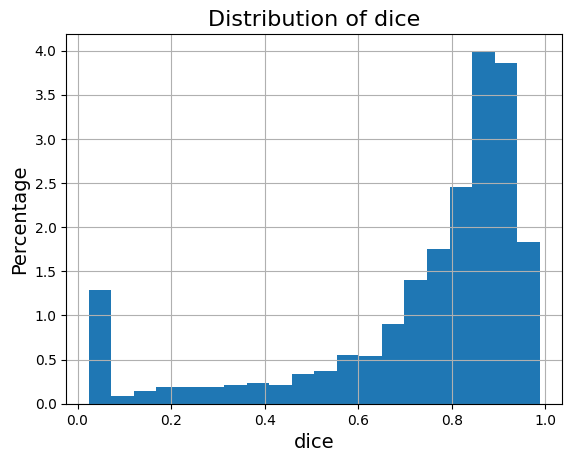

<Figure size 640x480 with 0 Axes>

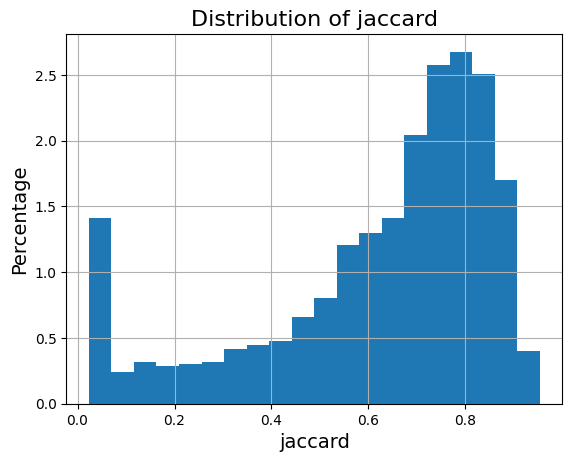

<Figure size 640x480 with 0 Axes>

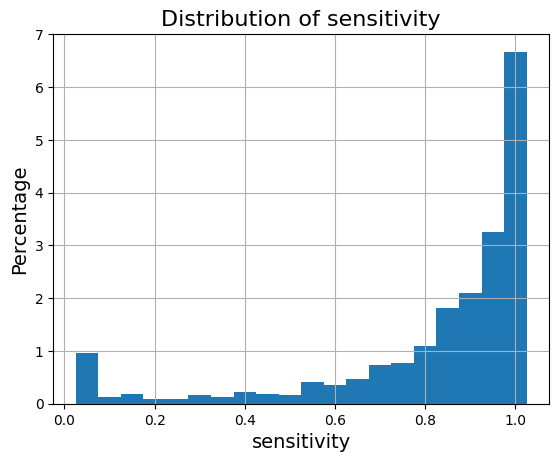

<Figure size 640x480 with 0 Axes>

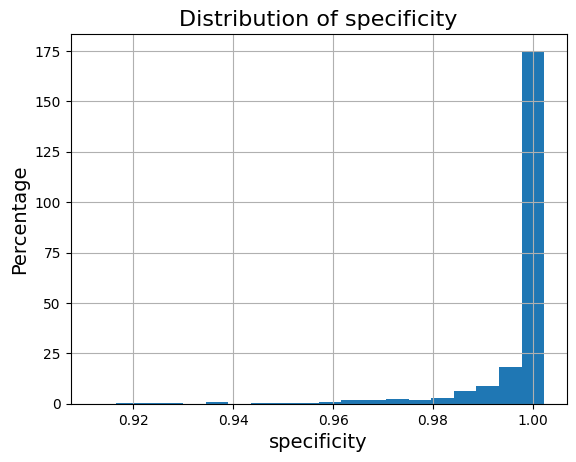

<Figure size 640x480 with 0 Axes>

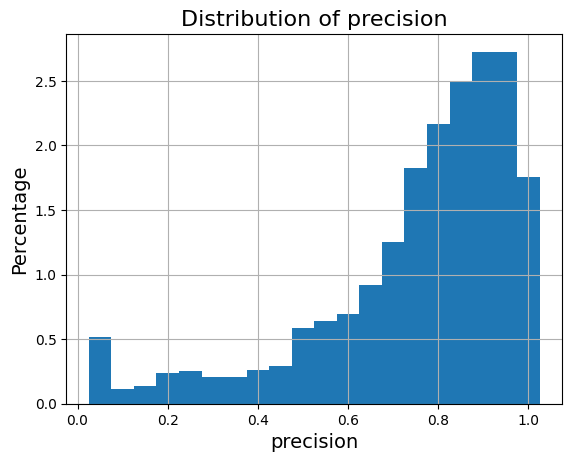

<Figure size 640x480 with 0 Axes>

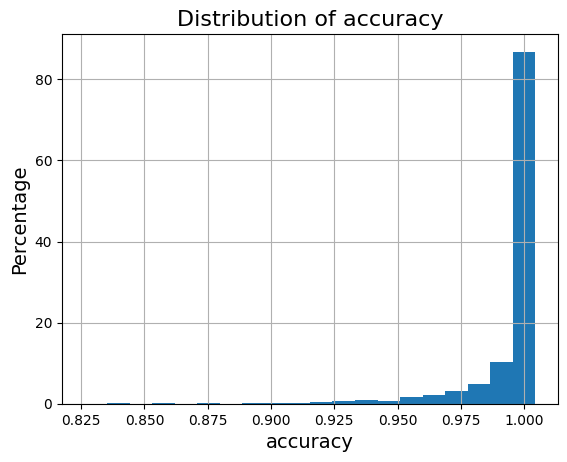

<Figure size 640x480 with 0 Axes>

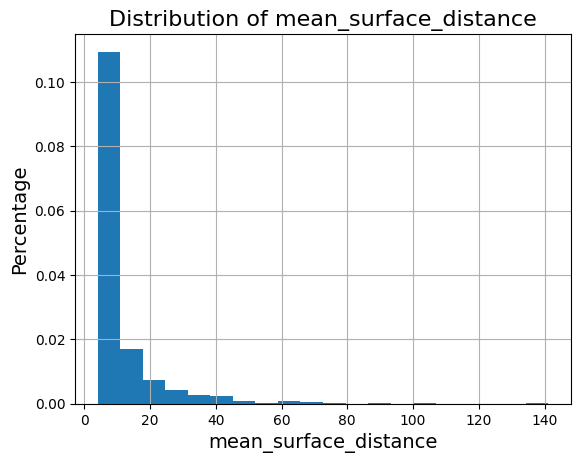

<Figure size 640x480 with 0 Axes>

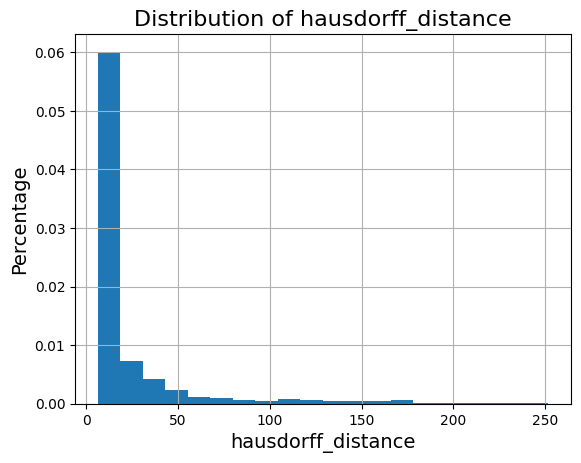

<Figure size 640x480 with 0 Axes>

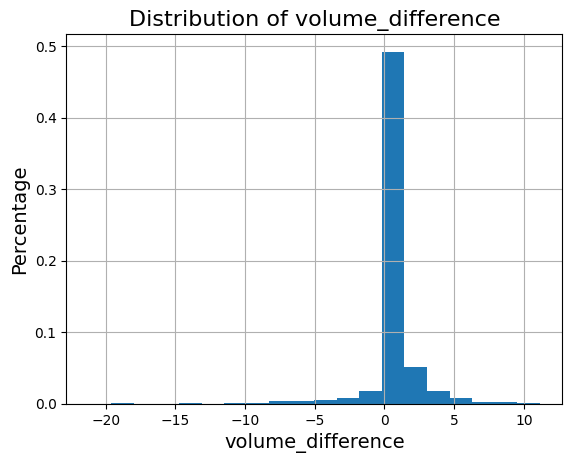

<Figure size 640x480 with 0 Axes>

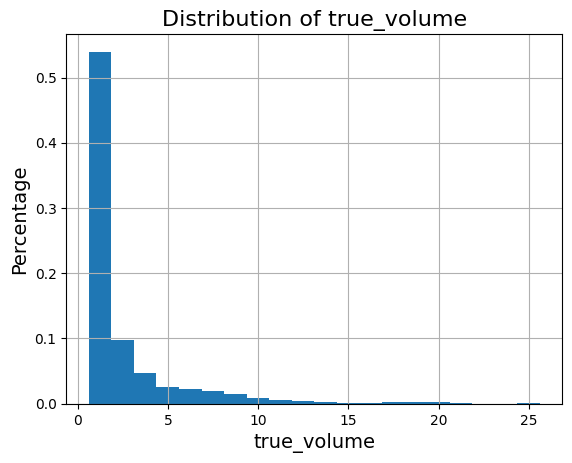

<Figure size 640x480 with 0 Axes>

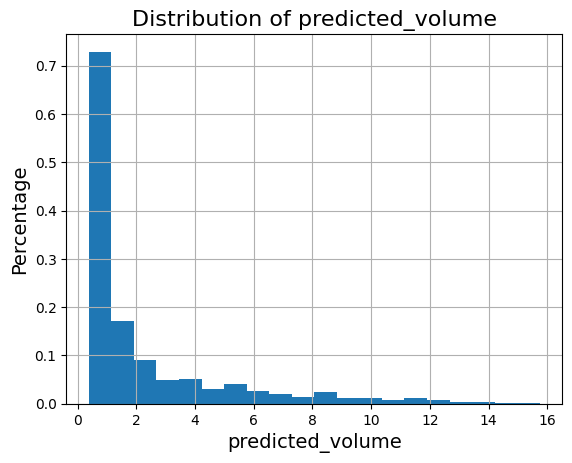

<Figure size 640x480 with 0 Axes>

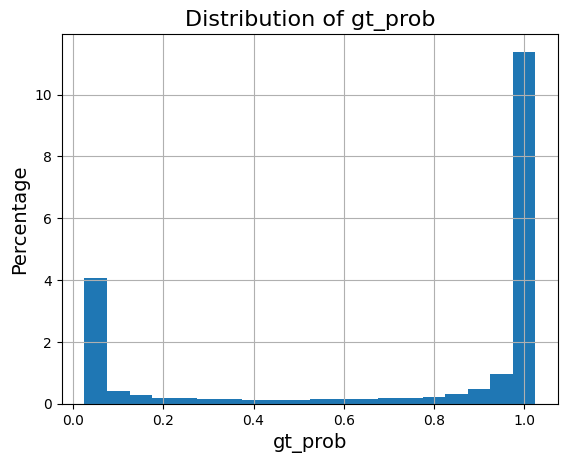

<Figure size 640x480 with 0 Axes>

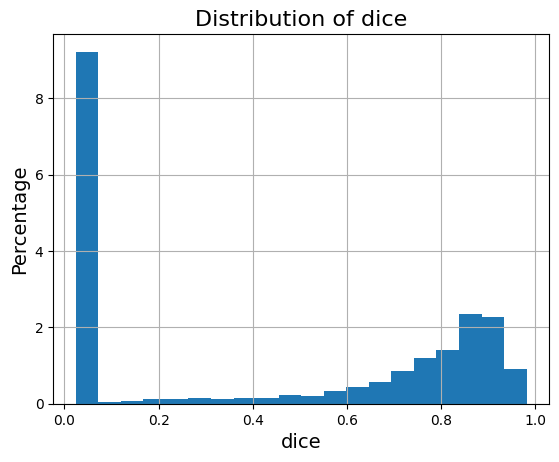

<Figure size 640x480 with 0 Axes>

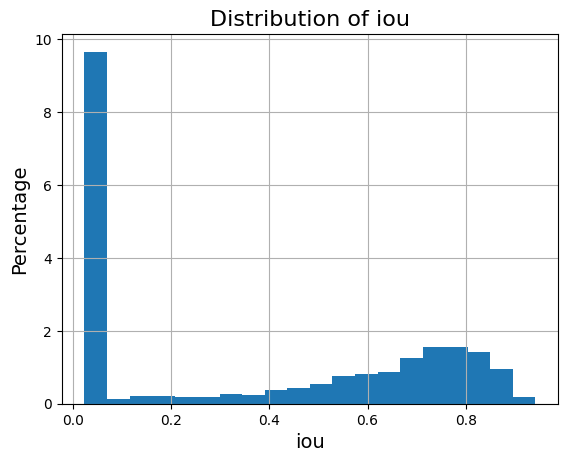

<Figure size 640x480 with 0 Axes>

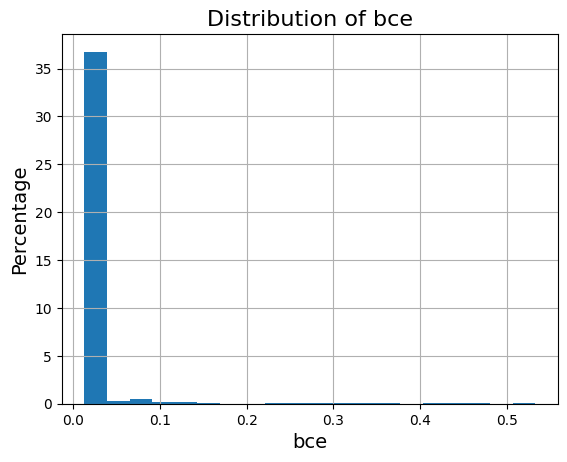

<Figure size 640x480 with 0 Axes>

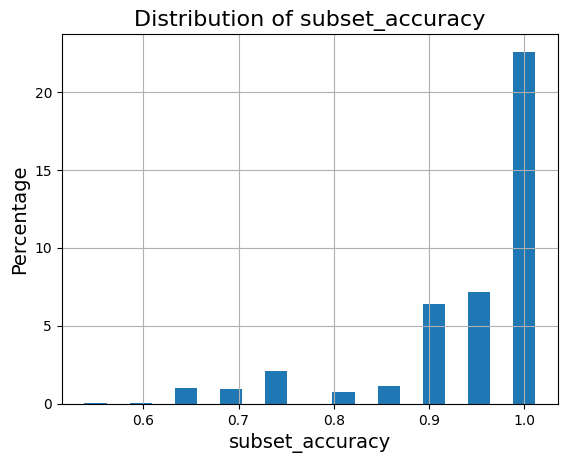

<Figure size 640x480 with 0 Axes>

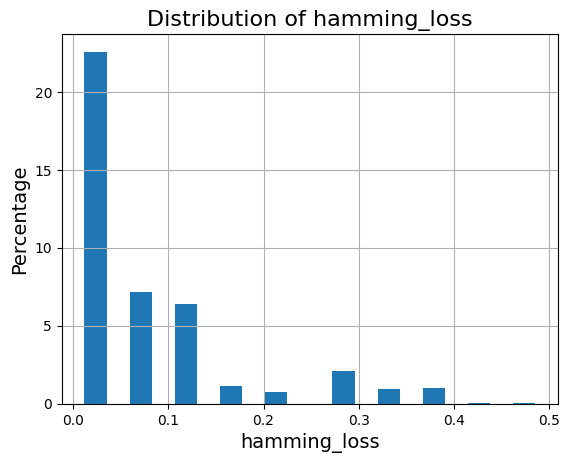

<Figure size 640x480 with 0 Axes>

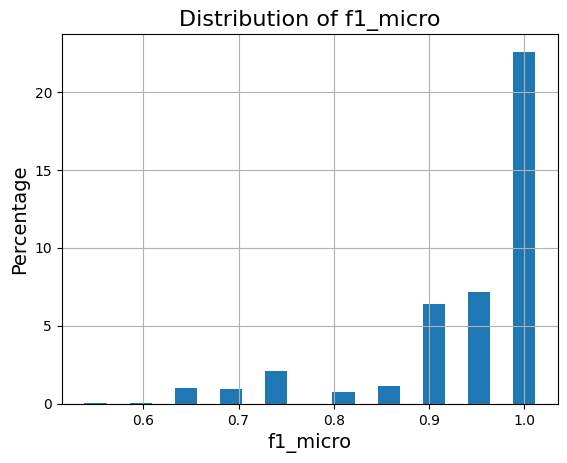

<Figure size 640x480 with 0 Axes>

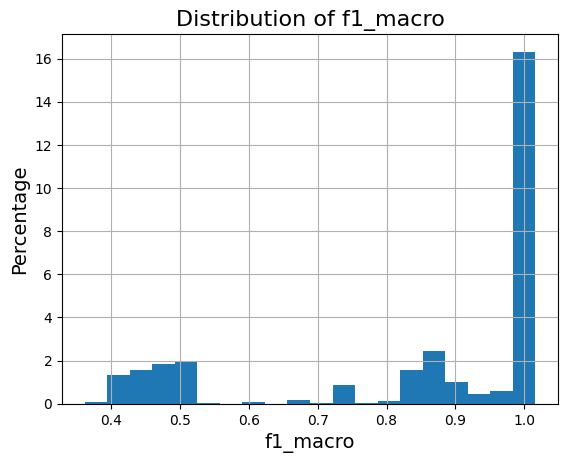

<Figure size 640x480 with 0 Axes>

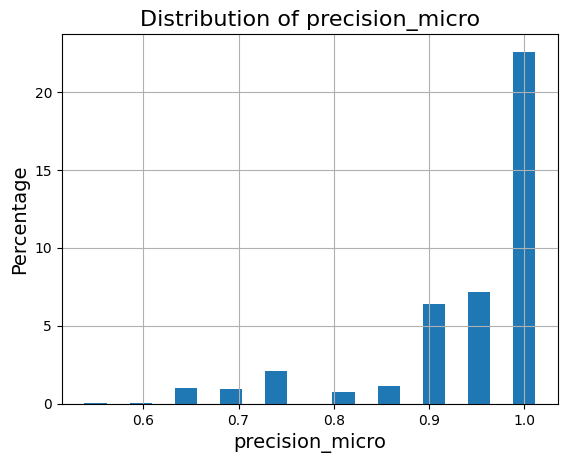

<Figure size 640x480 with 0 Axes>

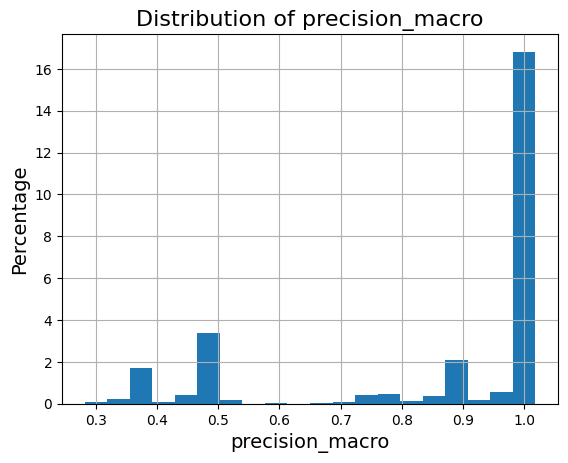

<Figure size 640x480 with 0 Axes>

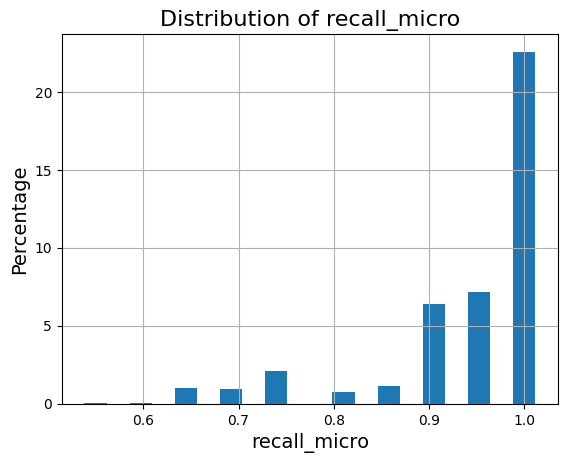

<Figure size 640x480 with 0 Axes>

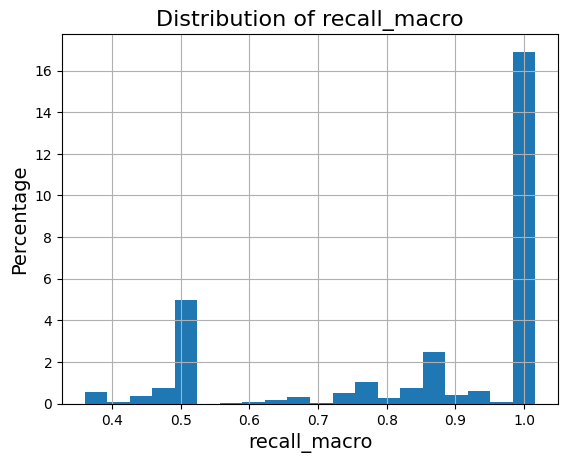

<Figure size 640x480 with 0 Axes>

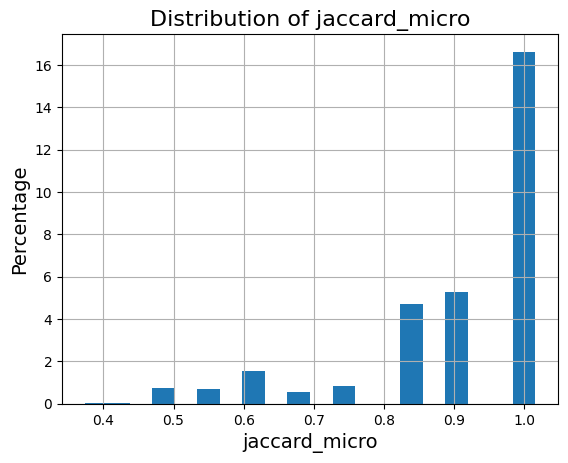

<Figure size 640x480 with 0 Axes>

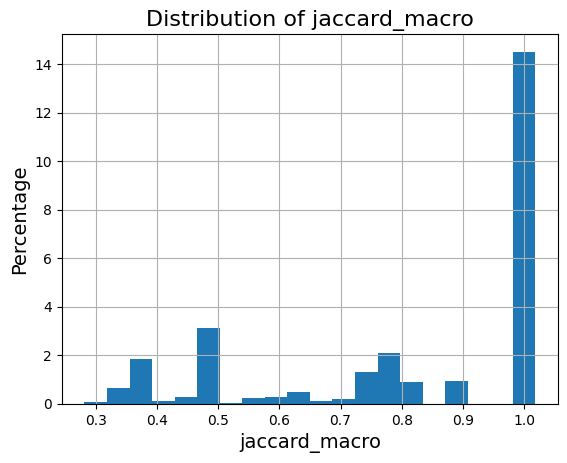

<Figure size 640x480 with 0 Axes>

In [159]:
plot_metric_distributions(seg_res['metric'], out_dir=output_dir, prefix="Segmentation metrics")
plot_metric_distributions(seg_res['losses'], out_dir=output_dir, prefix="Segmentation Loss")
plot_metric_distributions(cls_metrics, out_dir=output_dir, prefix="Teacher forcing classification")